### Importing Libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import os

### Reading train.csv and Data Analysis

In [2]:
train_csv = pd.read_csv("train.csv") # Imported the csv file
print(train_csv.shape)
## Mappings for converting labels to integers and vice-versa
label_to_int_map = {
    'bright dune':0,
    'dark dune':1,
    'spider':2,
    'impact ejecta':3,
    'slope streak':4,
    'swiss cheese':5,
    'crater':6,
    'other':7
} 
int_to_label_map = {v:k for k, v in label_to_int_map.items()}

(6201, 2)


In [3]:
file_names, labels = train_csv['File Name'], train_csv['Class'] 
pd.set_option('future.no_silent_downcasting', True)
labels_int = labels.replace(label_to_int_map).to_list() #Converting labels from text to integers

new_file_names = []
for file_name in file_names:
    new_file_names.append(os.path.join('train_dataset', file_name)) ## file name with path

## Splitting files from train_dataset train and test splits
x_train, x_test, y_train, y_test = train_test_split(new_file_names, labels_int, test_size=0.2) 

## Train and Test dataframes containing file names and integer label columns
train_df = pd.concat([pd.Series(x_train), pd.Series(y_train)], axis=1)
test_df = pd.concat([pd.Series(x_test), pd.Series(y_test)], axis=1)

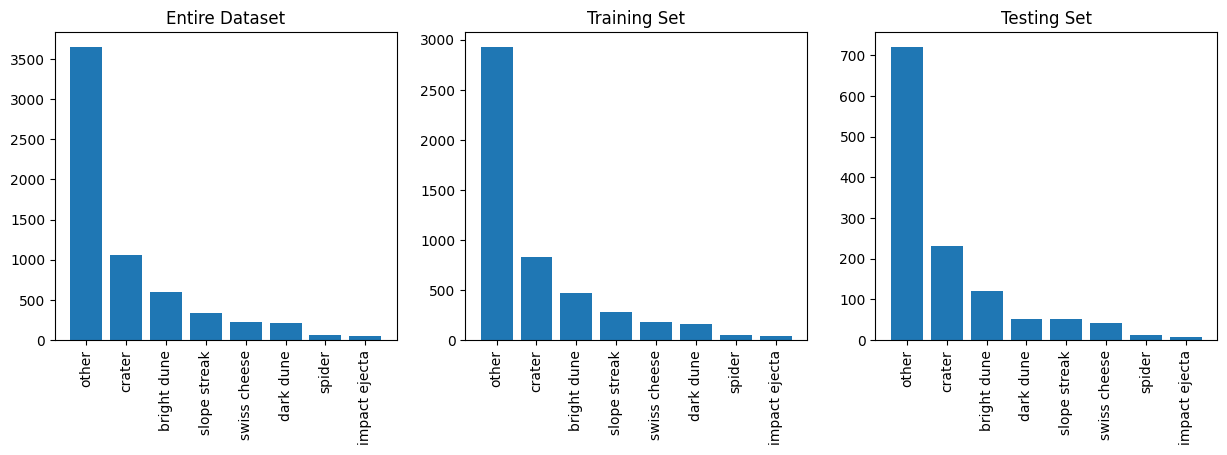

In [4]:
## Plotting the frequencies of different types of images available in the dataset, and training-testing splits

freq = pd.Series(labels_int).value_counts()
freq_train = train_df[1].value_counts()
freq_test = test_df[1].value_counts()

fig, ax = plt.subplots(1,3)

ax[0].bar([int_to_label_map[lab] for lab in freq.index ], freq)
ax[1].bar([int_to_label_map[lab] for lab in freq_train.index ], freq_train)
ax[2].bar([int_to_label_map[lab] for lab in freq_test.index ], freq_test)

ax[0].tick_params('x', labelrotation = 90)
ax[1].tick_params('x', labelrotation = 90)
ax[2].tick_params('x', labelrotation = 90)

ax[0].set_title("Entire Dataset")
ax[1].set_title("Training Set")
ax[2].set_title("Testing Set")

fig.set_figwidth(15)
fig.set_figheight(4)
plt.show()

### Importing the Images and creation of iterators for training
Images are imported as a PyTorch Dataset based on the filenames in the training and testing dataframes and the iterators are initiated

In [5]:
''' 
Creating a class that will take in the train/test filenames dataframe
as input and import and store images as a tuple: (image tensor, integer label)

'''
class MarsImgDataset(Dataset):
    def __init__(self, img_df, transform = None):
        super().__init__()
        self.frame = img_df
        self.transform = transform

    def __len__(self):
        return len(self.frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.frame.iloc[idx, 0]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = self.frame.iloc[idx, 1]
        sample = (image, label)
        
        return sample

In [6]:
IMAGE_SIZE = (227, 227) # Standardising the size for all images
data_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(), # Random flips
    ])

train_dataset = MarsImgDataset(train_df, data_transform)
test_dataset = MarsImgDataset(test_df, data_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True) # Initialise Training Loader
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True) # Initialise Testing Loader

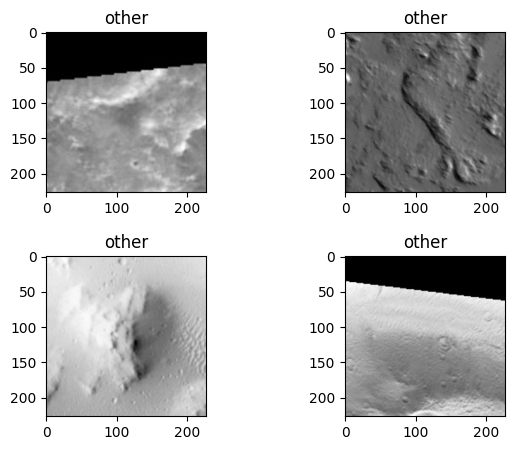

In [15]:
## Check the dataloaders by plotting the imported images
img, label = next(iter(test_loader))
figure, axis = plt.subplots(2,2)

axis[0,0].imshow(img[0].permute(1,2,0), cmap = 'Greys_r')
axis[0,0].set_title(int_to_label_map[label[0].item()])

axis[0,1].imshow(img[1].permute(1,2,0), cmap = 'Greys_r')
axis[0,1].set_title(int_to_label_map[label[1].item()])

axis[1,0].imshow(img[2].permute(1,2,0), cmap = 'Greys_r')
axis[1,0].set_title(int_to_label_map[label[2].item()])

axis[1,1].imshow(img[3].permute(1,2,0), cmap = 'Greys_r')
axis[1,1].set_title(int_to_label_map[label[3].item()])

plt.subplots_adjust(
    left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4
)

plt.show()
